In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import SequentialLR, LinearLR, MultiStepLR

In [3]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 128

#Excecutes the training transforms outlined in the paper as well as normalizing the images based on average pixel values from CIFAR-10
train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.482, 0.4465], std=[0.247, 0.2435, 0.2616]),
])

test_transform = transforms.ToTensor()

#Downloads datasets
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
train_size = 45000
val_size = 5000
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_dataset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=test_transform),
    val_dataset.indices
)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [4]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None


    def forward(self, x):
        #Keeps activation from previous layer to add as residual later
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        #Adds residual
        x += identity
        out = F.relu(x)
        return out


In [5]:
#Defines Residual Neural Network

class Resnet(nn.Module):
    def __init__(self, n):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.reslayers = nn.ModuleList()

        #Constructs model based on n parameter according to paper
        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=True))

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=True))

        for _ in range(n):
            self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))

        self.pool2 = nn.AvgPool2d(kernel_size=8,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function followed by global average pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        for reslayer in self.reslayers:
            x = reslayer(x)

        x = self.pool2(x)

        #Fully connected layer to outputs
        x = self.flatten(x)
        out = self.out(x)
        
        return out

In [6]:
#Method for He/Kaiming parameter initialization
def he_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [7]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train()
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate arrays to save our training data and plot it
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0
    save_every = 50 #Determines how often to print and save metrics

    for batch_index, data in enumerate(trainloader):

        #Executes forward, backward, and loss computation steps for training
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        #Prints metrics every certain number of batches
        if (batch_index+1) % save_every == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0


    return batches, losses, accuracy

    
#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):

    network.eval()

    #Used for tracking metrics
    running_loss = 0.0
    running_accuracy = 0.0

    #Evaluates validation data with no training involved
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    network.train()

    #Prints metrics
    avg_loss_across_batches = running_loss / len(valloader)
    avg_accuracy_across_batches = (running_accuracy / len(valloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

In [8]:
#Method for displaying metric graphics
def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Train Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Train Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Val Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Val Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Batch Number')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

Epoch 1
Batch50, Loss: 2.418, Accuracy: 17.7%
Batch100, Loss: 2.009, Accuracy: 23.4%
Batch150, Loss: 1.931, Accuracy: 27.9%
Batch200, Loss: 1.835, Accuracy: 31.3%
Batch250, Loss: 1.780, Accuracy: 32.6%
Batch300, Loss: 1.748, Accuracy: 33.8%
Batch350, Loss: 1.718, Accuracy: 34.5%
Val Loss: 3.491, Val Accuracy: 15.0%
*****************************************



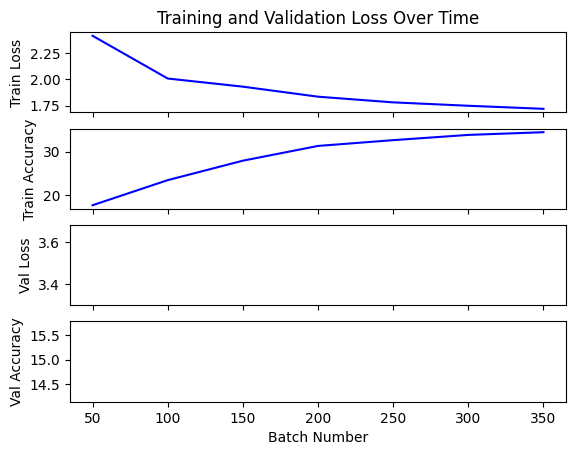

Epoch 2
Batch50, Loss: 1.857, Accuracy: 30.9%
Batch100, Loss: 1.651, Accuracy: 37.7%
Batch150, Loss: 1.568, Accuracy: 41.5%
Batch200, Loss: 1.445, Accuracy: 46.2%
Batch250, Loss: 1.416, Accuracy: 47.8%
Batch300, Loss: 1.380, Accuracy: 48.9%
Batch350, Loss: 1.288, Accuracy: 53.1%
Val Loss: 3.828, Val Accuracy: 12.0%
*****************************************



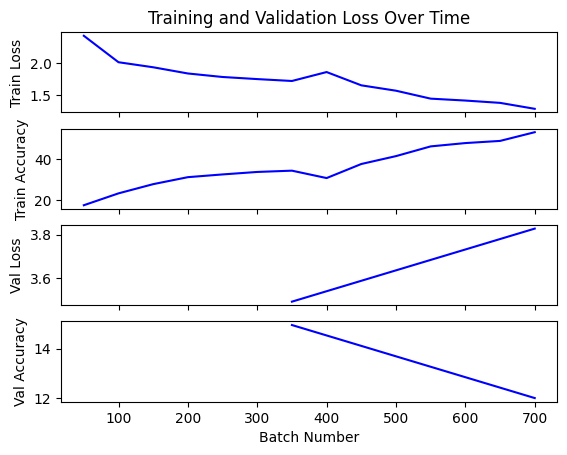

Epoch 3
Batch50, Loss: 1.391, Accuracy: 49.4%
Batch100, Loss: 1.341, Accuracy: 51.6%
Batch150, Loss: 1.284, Accuracy: 53.5%
Batch200, Loss: 1.191, Accuracy: 57.0%
Batch250, Loss: 1.199, Accuracy: 57.6%
Batch300, Loss: 1.121, Accuracy: 60.0%
Batch350, Loss: 1.082, Accuracy: 61.6%
Val Loss: 3.790, Val Accuracy: 14.8%
*****************************************



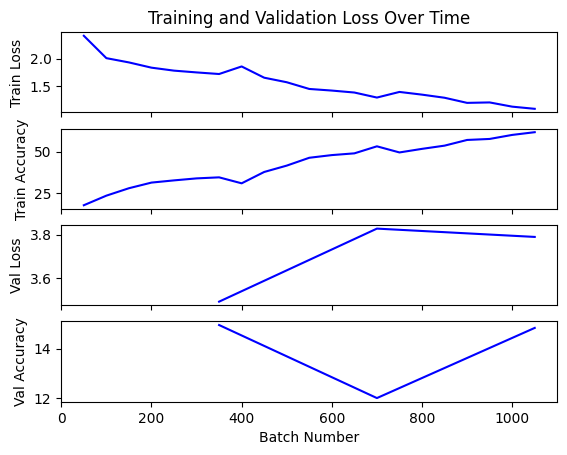

Epoch 4
Batch50, Loss: 1.126, Accuracy: 59.8%
Batch100, Loss: 1.082, Accuracy: 61.8%
Batch150, Loss: 1.078, Accuracy: 61.5%
Batch200, Loss: 1.016, Accuracy: 64.5%
Batch250, Loss: 1.036, Accuracy: 63.4%
Batch300, Loss: 0.991, Accuracy: 64.5%
Batch350, Loss: 0.978, Accuracy: 65.9%
Val Loss: 2.279, Val Accuracy: 23.5%
*****************************************



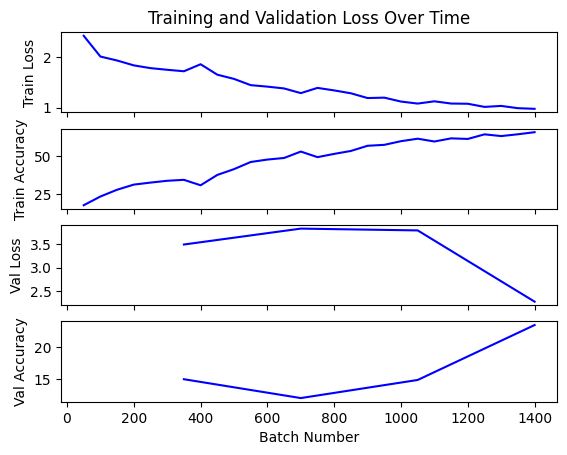

Epoch 5
Batch50, Loss: 0.970, Accuracy: 65.4%
Batch100, Loss: 0.960, Accuracy: 67.0%
Batch150, Loss: 0.928, Accuracy: 67.7%
Batch200, Loss: 0.948, Accuracy: 67.0%
Batch250, Loss: 0.901, Accuracy: 68.8%
Batch300, Loss: 0.861, Accuracy: 70.6%
Batch350, Loss: 0.860, Accuracy: 69.8%
Val Loss: 2.516, Val Accuracy: 27.7%
*****************************************



c:\Users\hagan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


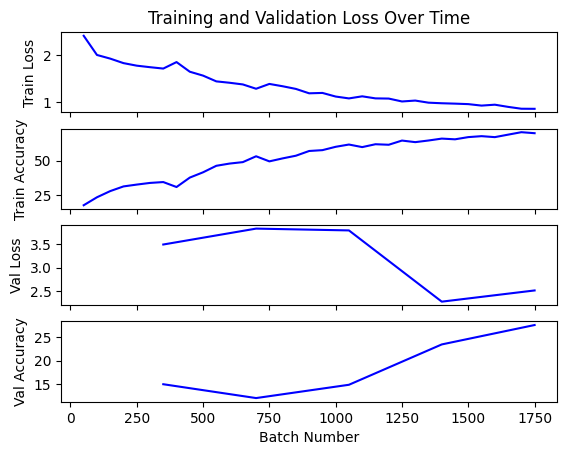

Epoch 6
Batch50, Loss: 0.854, Accuracy: 70.1%
Batch100, Loss: 0.872, Accuracy: 69.4%
Batch150, Loss: 0.839, Accuracy: 71.2%
Batch200, Loss: 0.845, Accuracy: 71.3%
Batch250, Loss: 0.850, Accuracy: 71.0%
Batch300, Loss: 0.800, Accuracy: 72.2%
Batch350, Loss: 0.824, Accuracy: 72.0%
Val Loss: 2.873, Val Accuracy: 22.3%
*****************************************



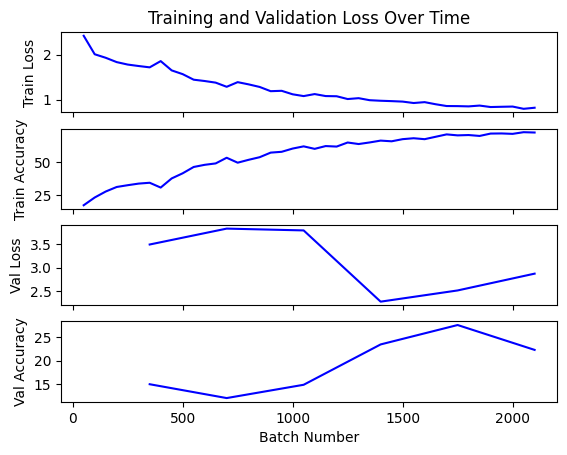

Epoch 7
Batch50, Loss: 0.753, Accuracy: 74.0%
Batch100, Loss: 0.776, Accuracy: 72.7%
Batch150, Loss: 0.748, Accuracy: 74.7%
Batch200, Loss: 0.779, Accuracy: 73.0%
Batch250, Loss: 0.763, Accuracy: 73.3%
Batch300, Loss: 0.741, Accuracy: 74.5%
Batch350, Loss: 0.707, Accuracy: 75.3%
Val Loss: 2.921, Val Accuracy: 26.7%
*****************************************



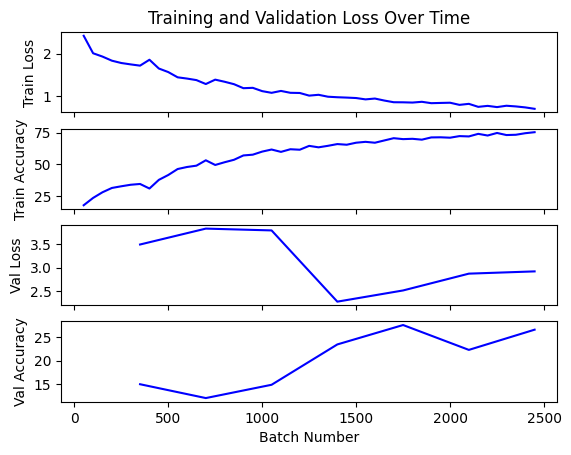

Epoch 8
Batch50, Loss: 0.716, Accuracy: 75.1%
Batch100, Loss: 0.733, Accuracy: 74.7%
Batch150, Loss: 0.678, Accuracy: 76.3%
Batch200, Loss: 0.699, Accuracy: 75.0%
Batch250, Loss: 0.684, Accuracy: 76.6%
Batch300, Loss: 0.668, Accuracy: 76.9%
Batch350, Loss: 0.661, Accuracy: 77.6%
Val Loss: 2.611, Val Accuracy: 23.9%
*****************************************



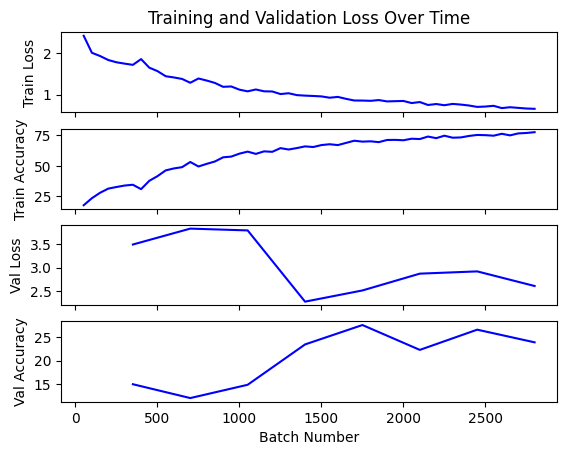

Epoch 9
Batch50, Loss: 0.654, Accuracy: 77.3%
Batch100, Loss: 0.645, Accuracy: 77.7%
Batch150, Loss: 0.631, Accuracy: 77.7%
Batch200, Loss: 0.650, Accuracy: 77.1%
Batch250, Loss: 0.664, Accuracy: 76.5%
Batch300, Loss: 0.664, Accuracy: 77.3%
Batch350, Loss: 0.633, Accuracy: 77.8%
Val Loss: 2.187, Val Accuracy: 32.5%
*****************************************



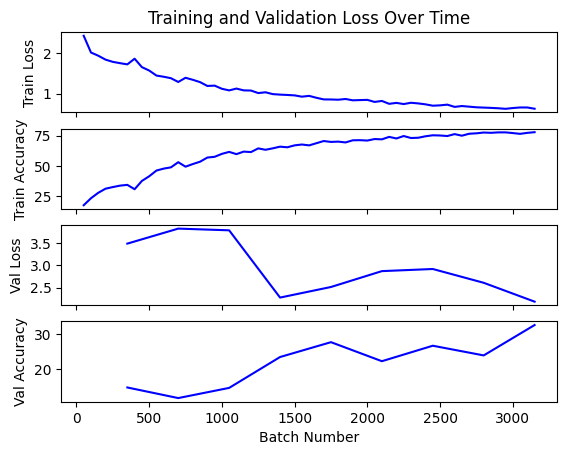

Epoch 10
Batch50, Loss: 0.645, Accuracy: 78.1%
Batch100, Loss: 0.632, Accuracy: 78.9%
Batch150, Loss: 0.603, Accuracy: 79.7%
Batch200, Loss: 0.593, Accuracy: 79.4%
Batch250, Loss: 0.628, Accuracy: 78.3%
Batch300, Loss: 0.627, Accuracy: 79.0%
Batch350, Loss: 0.595, Accuracy: 79.7%
Val Loss: 2.071, Val Accuracy: 32.1%
*****************************************



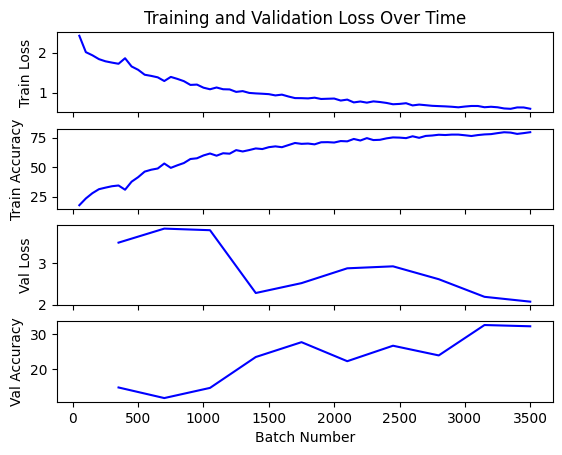

Epoch 11
Batch50, Loss: 0.601, Accuracy: 79.0%
Batch100, Loss: 0.604, Accuracy: 79.1%
Batch150, Loss: 0.582, Accuracy: 80.1%
Batch200, Loss: 0.565, Accuracy: 80.5%
Batch250, Loss: 0.625, Accuracy: 78.2%
Batch300, Loss: 0.589, Accuracy: 79.8%
Batch350, Loss: 0.614, Accuracy: 78.5%
Val Loss: 2.620, Val Accuracy: 23.1%
*****************************************



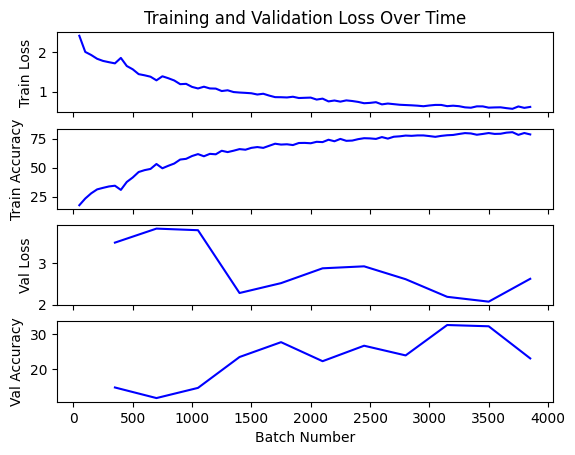

Epoch 12
Batch50, Loss: 0.550, Accuracy: 81.0%
Batch100, Loss: 0.552, Accuracy: 81.3%
Batch150, Loss: 0.553, Accuracy: 80.5%
Batch200, Loss: 0.540, Accuracy: 81.4%
Batch250, Loss: 0.557, Accuracy: 81.3%
Batch300, Loss: 0.550, Accuracy: 80.9%
Batch350, Loss: 0.582, Accuracy: 80.0%
Val Loss: 3.081, Val Accuracy: 28.8%
*****************************************



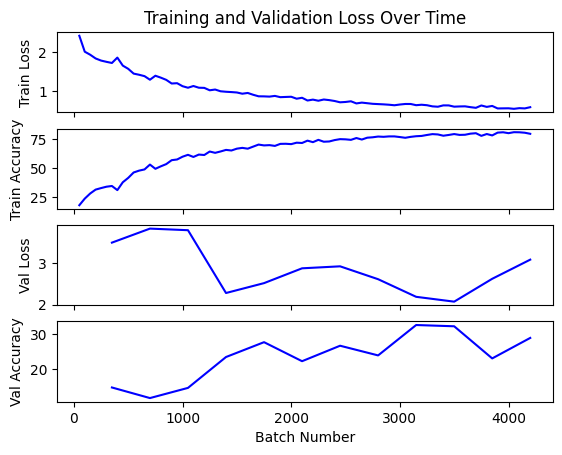

Epoch 13
Batch50, Loss: 0.527, Accuracy: 81.5%
Batch100, Loss: 0.570, Accuracy: 80.4%
Batch150, Loss: 0.544, Accuracy: 81.0%
Batch200, Loss: 0.532, Accuracy: 82.2%
Batch250, Loss: 0.550, Accuracy: 80.9%
Batch300, Loss: 0.564, Accuracy: 80.8%
Batch350, Loss: 0.557, Accuracy: 80.5%
Val Loss: 2.194, Val Accuracy: 31.1%
*****************************************



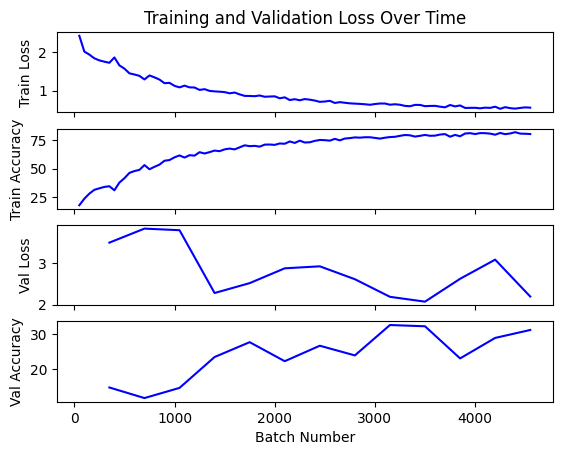

Epoch 14
Batch50, Loss: 0.514, Accuracy: 81.9%
Batch100, Loss: 0.529, Accuracy: 81.4%
Batch150, Loss: 0.536, Accuracy: 81.2%
Batch200, Loss: 0.533, Accuracy: 81.8%
Batch250, Loss: 0.525, Accuracy: 82.1%
Batch300, Loss: 0.512, Accuracy: 82.8%
Batch350, Loss: 0.523, Accuracy: 81.5%
Val Loss: 2.493, Val Accuracy: 28.5%
*****************************************



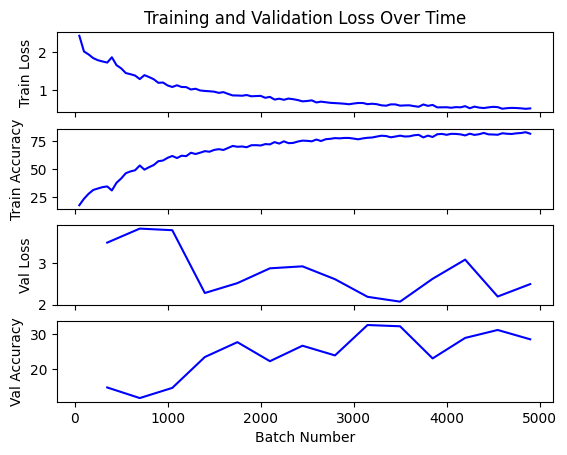

Epoch 15
Batch50, Loss: 0.498, Accuracy: 83.5%
Batch100, Loss: 0.505, Accuracy: 82.5%
Batch150, Loss: 0.512, Accuracy: 82.8%
Batch200, Loss: 0.511, Accuracy: 82.1%
Batch250, Loss: 0.521, Accuracy: 81.7%
Batch300, Loss: 0.515, Accuracy: 82.1%
Batch350, Loss: 0.516, Accuracy: 82.2%
Val Loss: 2.239, Val Accuracy: 25.4%
*****************************************



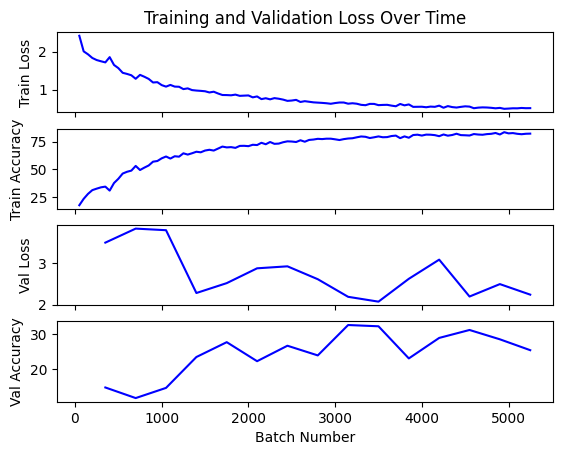

Epoch 16
Batch50, Loss: 0.494, Accuracy: 83.2%
Batch100, Loss: 0.531, Accuracy: 81.2%
Batch150, Loss: 0.519, Accuracy: 82.2%
Batch200, Loss: 0.494, Accuracy: 83.1%
Batch250, Loss: 0.496, Accuracy: 82.7%
Batch300, Loss: 0.490, Accuracy: 83.0%
Batch350, Loss: 0.504, Accuracy: 82.9%
Val Loss: 2.339, Val Accuracy: 34.9%
*****************************************



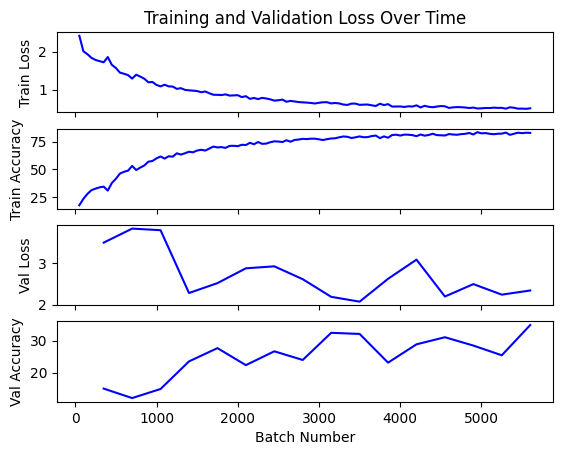

Epoch 17
Batch50, Loss: 0.456, Accuracy: 84.0%
Batch100, Loss: 0.501, Accuracy: 83.2%
Batch150, Loss: 0.524, Accuracy: 82.2%
Batch200, Loss: 0.478, Accuracy: 83.2%
Batch250, Loss: 0.476, Accuracy: 83.4%
Batch300, Loss: 0.474, Accuracy: 83.9%
Batch350, Loss: 0.488, Accuracy: 83.1%
Val Loss: 1.990, Val Accuracy: 41.0%
*****************************************



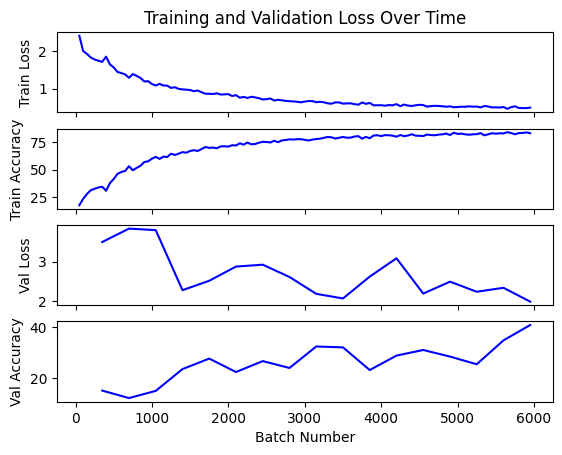

Epoch 18
Batch50, Loss: 0.466, Accuracy: 84.0%
Batch100, Loss: 0.450, Accuracy: 84.3%
Batch150, Loss: 0.463, Accuracy: 84.2%
Batch200, Loss: 0.460, Accuracy: 83.9%
Batch250, Loss: 0.475, Accuracy: 83.5%
Batch300, Loss: 0.492, Accuracy: 83.2%
Batch350, Loss: 0.465, Accuracy: 83.3%
Val Loss: 1.920, Val Accuracy: 42.1%
*****************************************



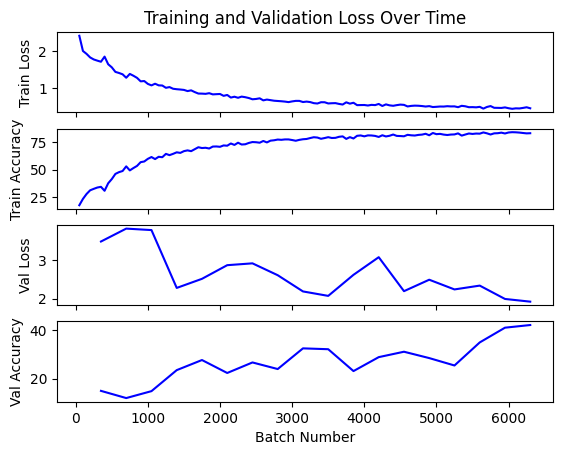

Epoch 19
Batch50, Loss: 0.469, Accuracy: 84.4%
Batch100, Loss: 0.468, Accuracy: 83.7%
Batch150, Loss: 0.463, Accuracy: 84.0%
Batch200, Loss: 0.453, Accuracy: 84.0%
Batch250, Loss: 0.463, Accuracy: 84.2%
Batch300, Loss: 0.482, Accuracy: 83.3%
Batch350, Loss: 0.485, Accuracy: 83.3%
Val Loss: 1.981, Val Accuracy: 40.1%
*****************************************



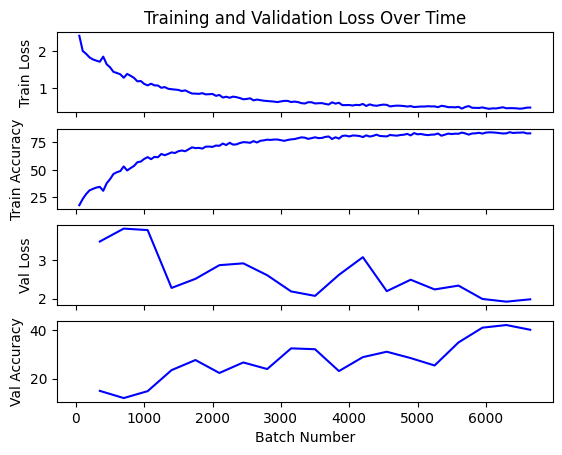

Epoch 20
Batch50, Loss: 0.463, Accuracy: 83.8%
Batch100, Loss: 0.448, Accuracy: 84.0%
Batch150, Loss: 0.462, Accuracy: 83.7%
Batch200, Loss: 0.457, Accuracy: 84.1%
Batch250, Loss: 0.428, Accuracy: 85.2%
Batch300, Loss: 0.450, Accuracy: 83.9%
Batch350, Loss: 0.489, Accuracy: 83.6%
Val Loss: 1.843, Val Accuracy: 39.6%
*****************************************



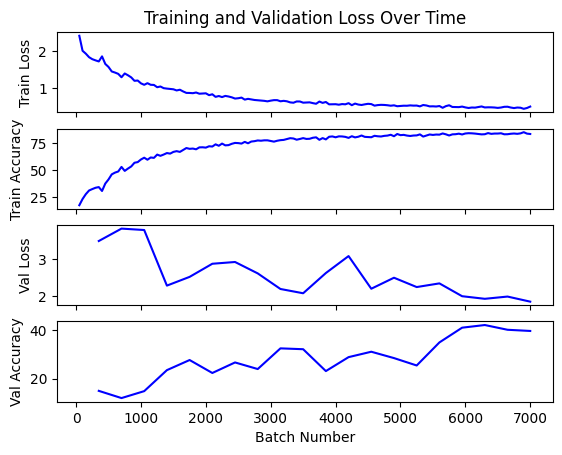

Epoch 21
Batch50, Loss: 0.414, Accuracy: 85.8%
Batch100, Loss: 0.449, Accuracy: 84.5%
Batch150, Loss: 0.446, Accuracy: 84.5%
Batch200, Loss: 0.446, Accuracy: 84.2%
Batch250, Loss: 0.448, Accuracy: 84.5%
Batch300, Loss: 0.470, Accuracy: 84.1%
Batch350, Loss: 0.434, Accuracy: 85.2%
Val Loss: 2.444, Val Accuracy: 35.8%
*****************************************



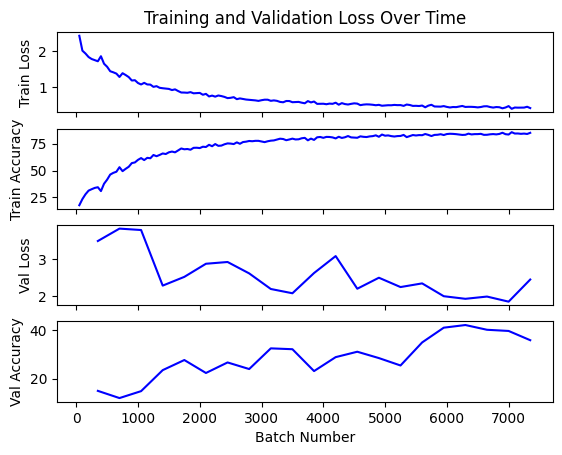

Epoch 22
Batch50, Loss: 0.427, Accuracy: 84.6%
Batch100, Loss: 0.414, Accuracy: 85.8%
Batch150, Loss: 0.432, Accuracy: 85.3%
Batch200, Loss: 0.431, Accuracy: 85.4%
Batch250, Loss: 0.442, Accuracy: 85.0%
Batch300, Loss: 0.428, Accuracy: 85.3%
Batch350, Loss: 0.433, Accuracy: 84.9%
Val Loss: 2.150, Val Accuracy: 34.7%
*****************************************



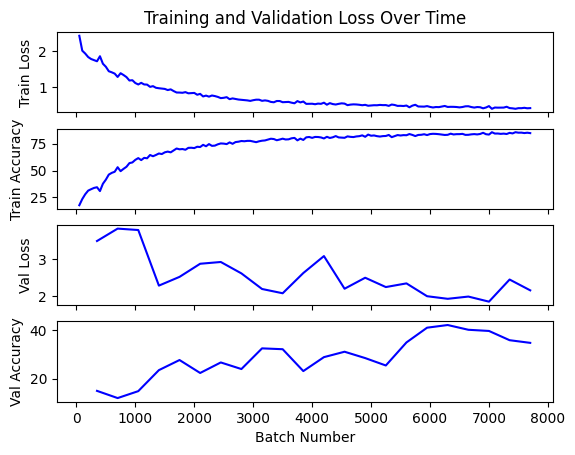

Epoch 23
Batch50, Loss: 0.408, Accuracy: 85.8%
Batch100, Loss: 0.429, Accuracy: 85.3%
Batch150, Loss: 0.412, Accuracy: 85.7%
Batch200, Loss: 0.419, Accuracy: 85.5%
Batch250, Loss: 0.429, Accuracy: 85.4%
Batch300, Loss: 0.440, Accuracy: 84.1%
Batch350, Loss: 0.436, Accuracy: 84.4%
Val Loss: 2.204, Val Accuracy: 33.7%
*****************************************



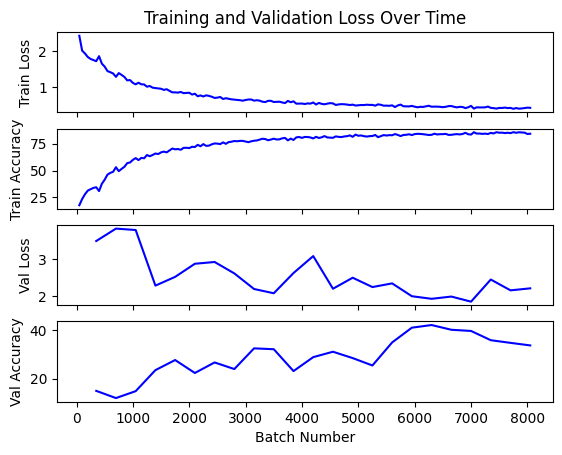

Epoch 24
Batch50, Loss: 0.416, Accuracy: 85.7%
Batch100, Loss: 0.416, Accuracy: 86.1%
Batch150, Loss: 0.408, Accuracy: 85.7%
Batch200, Loss: 0.412, Accuracy: 85.5%
Batch250, Loss: 0.431, Accuracy: 85.3%
Batch300, Loss: 0.412, Accuracy: 85.6%
Batch350, Loss: 0.438, Accuracy: 84.8%
Val Loss: 2.774, Val Accuracy: 29.8%
*****************************************



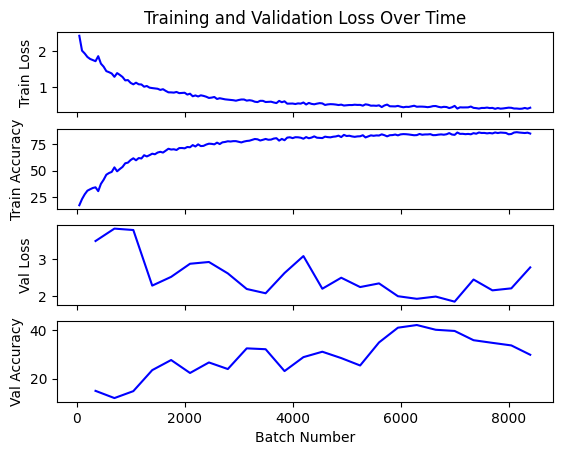

Epoch 25
Batch50, Loss: 0.385, Accuracy: 86.0%
Batch100, Loss: 0.416, Accuracy: 86.0%
Batch150, Loss: 0.410, Accuracy: 85.8%
Batch200, Loss: 0.430, Accuracy: 84.8%
Batch250, Loss: 0.424, Accuracy: 85.3%
Batch300, Loss: 0.410, Accuracy: 85.9%
Batch350, Loss: 0.443, Accuracy: 84.8%
Val Loss: 2.193, Val Accuracy: 39.6%
*****************************************



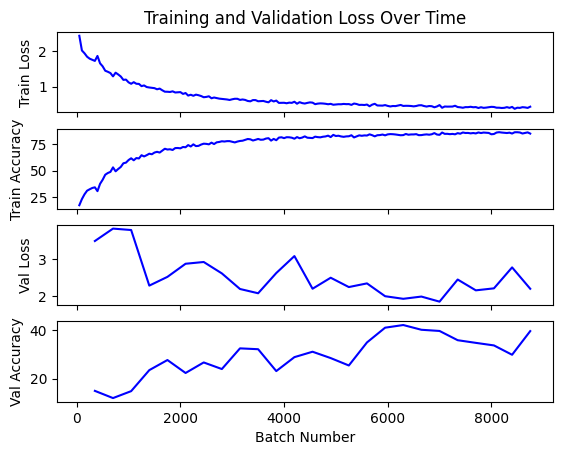

Epoch 26
Batch50, Loss: 0.376, Accuracy: 87.0%
Batch100, Loss: 0.307, Accuracy: 89.5%
Batch150, Loss: 0.303, Accuracy: 89.5%
Batch200, Loss: 0.282, Accuracy: 90.6%
Batch250, Loss: 0.290, Accuracy: 90.6%
Batch300, Loss: 0.285, Accuracy: 90.1%
Batch350, Loss: 0.284, Accuracy: 90.3%
Val Loss: 1.773, Val Accuracy: 43.6%
*****************************************



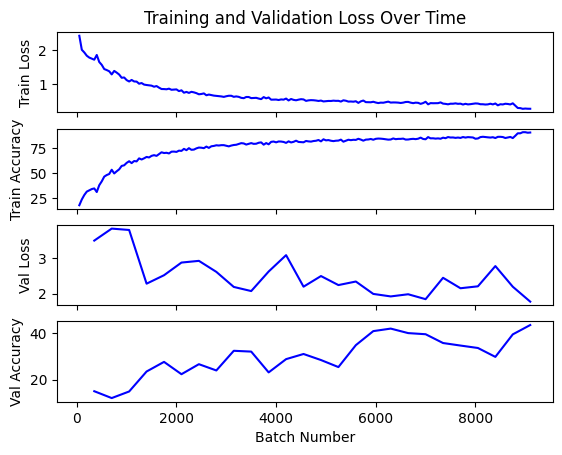

Epoch 27
Batch50, Loss: 0.258, Accuracy: 91.1%
Batch100, Loss: 0.283, Accuracy: 90.3%
Batch150, Loss: 0.253, Accuracy: 91.5%
Batch200, Loss: 0.264, Accuracy: 91.1%
Batch250, Loss: 0.263, Accuracy: 91.0%
Batch300, Loss: 0.250, Accuracy: 91.4%
Batch350, Loss: 0.257, Accuracy: 91.0%
Val Loss: 1.940, Val Accuracy: 40.4%
*****************************************



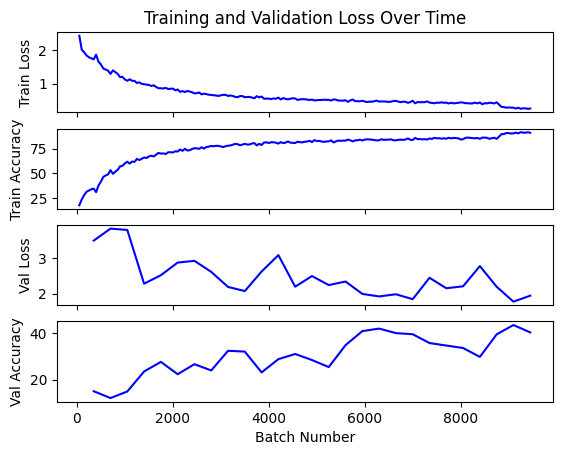

Epoch 28
Batch50, Loss: 0.248, Accuracy: 91.6%
Batch100, Loss: 0.246, Accuracy: 91.8%
Batch150, Loss: 0.255, Accuracy: 91.1%
Batch200, Loss: 0.246, Accuracy: 91.5%
Batch250, Loss: 0.271, Accuracy: 90.2%
Batch300, Loss: 0.243, Accuracy: 91.9%
Batch350, Loss: 0.245, Accuracy: 91.7%
Val Loss: 1.903, Val Accuracy: 46.1%
*****************************************



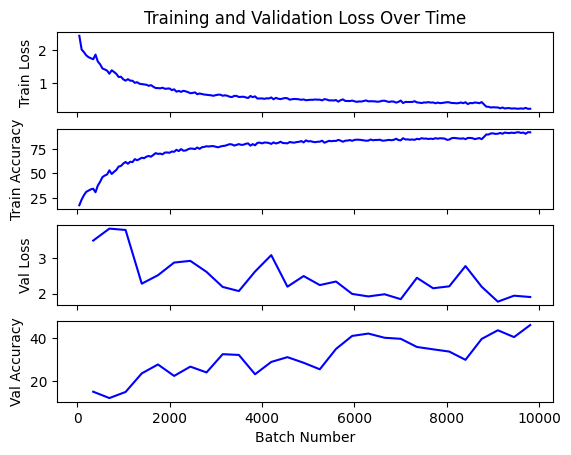

Epoch 29
Batch50, Loss: 0.235, Accuracy: 91.6%
Batch100, Loss: 0.238, Accuracy: 92.0%
Batch150, Loss: 0.243, Accuracy: 91.9%
Batch200, Loss: 0.224, Accuracy: 92.0%
Batch250, Loss: 0.248, Accuracy: 91.6%
Batch300, Loss: 0.242, Accuracy: 91.8%
Batch350, Loss: 0.230, Accuracy: 91.5%
Val Loss: 1.788, Val Accuracy: 45.9%
*****************************************



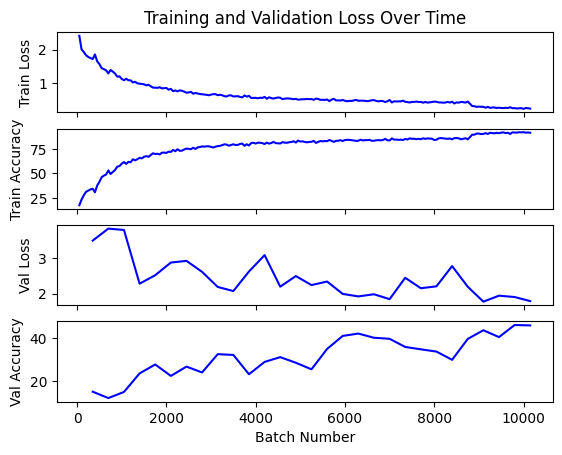

Epoch 30
Batch50, Loss: 0.231, Accuracy: 92.1%
Batch100, Loss: 0.223, Accuracy: 92.4%
Batch150, Loss: 0.229, Accuracy: 92.2%
Batch200, Loss: 0.221, Accuracy: 92.2%
Batch250, Loss: 0.224, Accuracy: 92.4%
Batch300, Loss: 0.234, Accuracy: 91.9%
Batch350, Loss: 0.235, Accuracy: 91.9%
Val Loss: 1.822, Val Accuracy: 49.0%
*****************************************



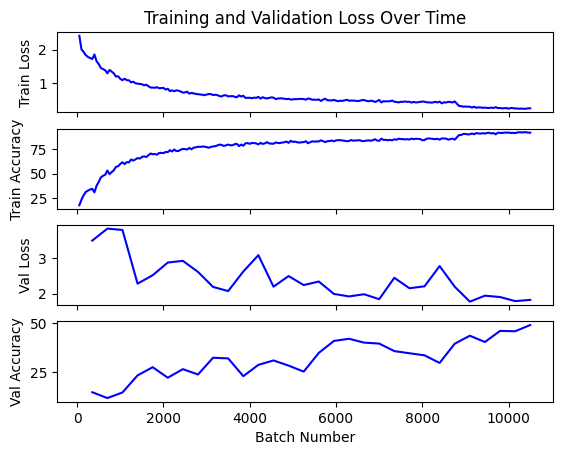

Epoch 31
Batch50, Loss: 0.219, Accuracy: 92.6%
Batch100, Loss: 0.225, Accuracy: 92.2%
Batch150, Loss: 0.214, Accuracy: 92.5%
Batch200, Loss: 0.217, Accuracy: 92.5%
Batch250, Loss: 0.216, Accuracy: 92.2%
Batch300, Loss: 0.214, Accuracy: 92.3%
Batch350, Loss: 0.232, Accuracy: 92.1%
Val Loss: 1.772, Val Accuracy: 46.7%
*****************************************



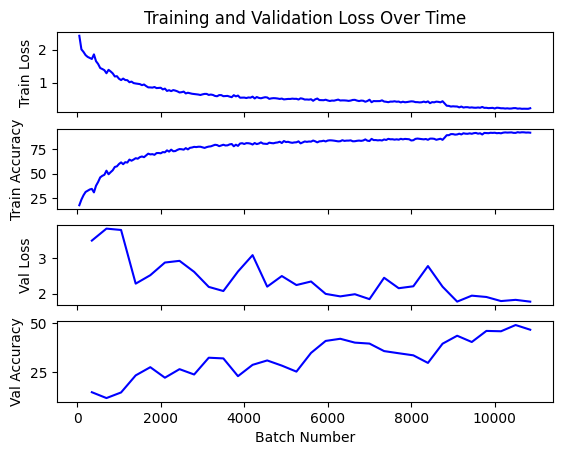

Epoch 32
Batch50, Loss: 0.198, Accuracy: 93.1%
Batch100, Loss: 0.220, Accuracy: 92.5%
Batch150, Loss: 0.235, Accuracy: 92.1%
Batch200, Loss: 0.213, Accuracy: 92.6%
Batch250, Loss: 0.215, Accuracy: 92.7%
Batch300, Loss: 0.211, Accuracy: 92.8%
Batch350, Loss: 0.214, Accuracy: 92.4%
Val Loss: 1.986, Val Accuracy: 41.9%
*****************************************



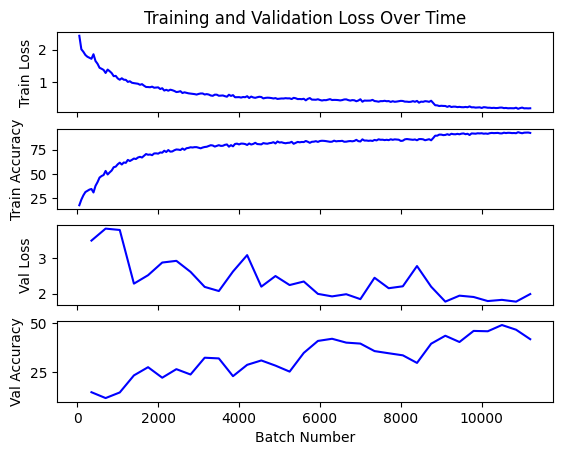

Epoch 33
Batch50, Loss: 0.199, Accuracy: 93.1%
Batch100, Loss: 0.209, Accuracy: 92.9%
Batch150, Loss: 0.204, Accuracy: 92.7%
Batch200, Loss: 0.198, Accuracy: 93.1%
Batch250, Loss: 0.210, Accuracy: 92.8%
Batch300, Loss: 0.216, Accuracy: 92.7%
Batch350, Loss: 0.212, Accuracy: 92.7%
Val Loss: 1.939, Val Accuracy: 45.2%
*****************************************



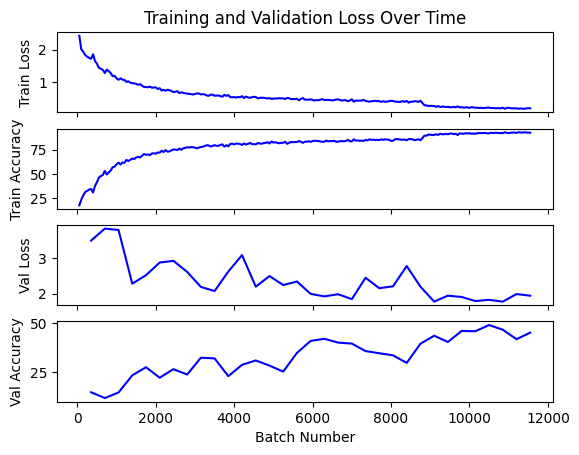

Epoch 34
Batch50, Loss: 0.202, Accuracy: 92.8%
Batch100, Loss: 0.211, Accuracy: 93.1%
Batch150, Loss: 0.200, Accuracy: 93.3%
Batch200, Loss: 0.201, Accuracy: 92.8%
Batch250, Loss: 0.199, Accuracy: 93.0%
Batch300, Loss: 0.199, Accuracy: 93.2%
Batch350, Loss: 0.213, Accuracy: 92.6%
Val Loss: 1.951, Val Accuracy: 42.9%
*****************************************



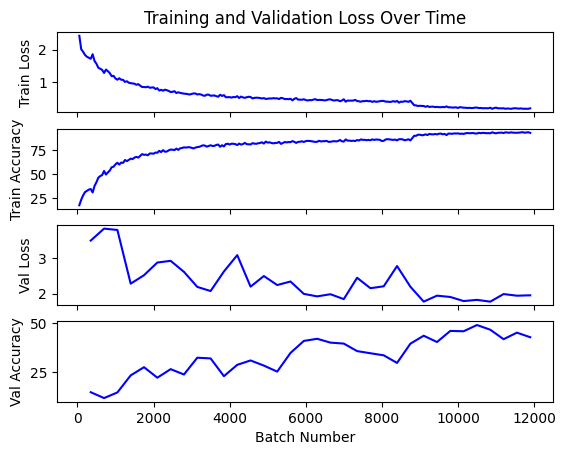

Epoch 35
Batch50, Loss: 0.192, Accuracy: 93.7%
Batch100, Loss: 0.203, Accuracy: 93.0%
Batch150, Loss: 0.189, Accuracy: 93.6%
Batch200, Loss: 0.196, Accuracy: 93.0%
Batch250, Loss: 0.207, Accuracy: 92.8%
Batch300, Loss: 0.200, Accuracy: 93.0%
Batch350, Loss: 0.204, Accuracy: 92.5%
Val Loss: 2.080, Val Accuracy: 41.7%
*****************************************



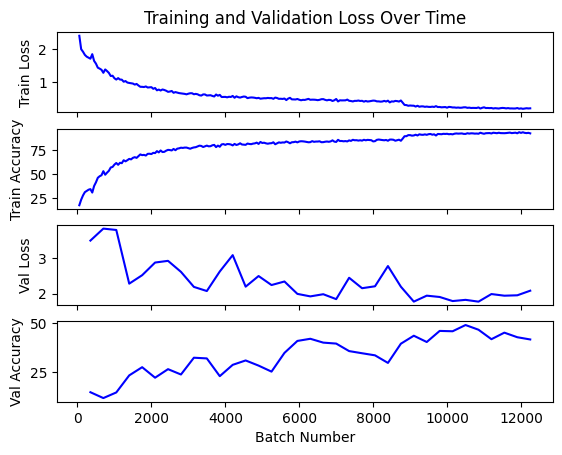

Epoch 36
Batch50, Loss: 0.191, Accuracy: 93.4%
Batch100, Loss: 0.195, Accuracy: 93.5%
Batch150, Loss: 0.178, Accuracy: 93.8%
Batch200, Loss: 0.186, Accuracy: 93.7%
Batch250, Loss: 0.172, Accuracy: 94.2%
Batch300, Loss: 0.183, Accuracy: 93.5%
Batch350, Loss: 0.178, Accuracy: 93.7%
Val Loss: 1.979, Val Accuracy: 43.3%
*****************************************



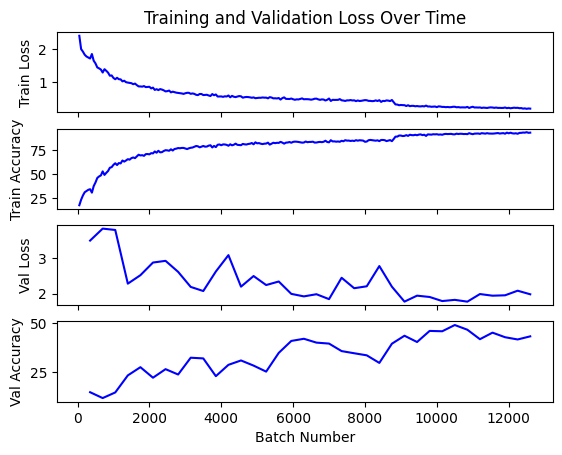

Epoch 37
Batch50, Loss: 0.185, Accuracy: 93.6%
Batch100, Loss: 0.192, Accuracy: 93.5%
Batch150, Loss: 0.186, Accuracy: 93.9%
Batch200, Loss: 0.180, Accuracy: 93.7%
Batch250, Loss: 0.183, Accuracy: 93.5%
Batch300, Loss: 0.176, Accuracy: 94.0%
Batch350, Loss: 0.176, Accuracy: 94.0%
Val Loss: 1.984, Val Accuracy: 43.8%
*****************************************



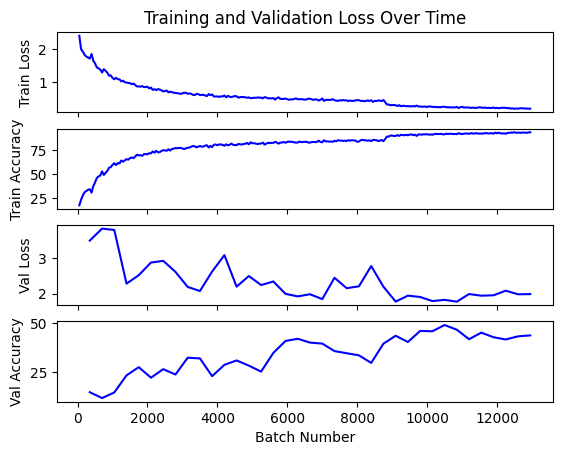

Epoch 38
Batch50, Loss: 0.183, Accuracy: 93.6%
Batch100, Loss: 0.184, Accuracy: 93.5%
Batch150, Loss: 0.190, Accuracy: 93.1%
Batch200, Loss: 0.179, Accuracy: 94.1%
Batch250, Loss: 0.172, Accuracy: 94.1%
Batch300, Loss: 0.173, Accuracy: 94.1%
Batch350, Loss: 0.185, Accuracy: 93.7%
Val Loss: 1.871, Val Accuracy: 46.2%
*****************************************



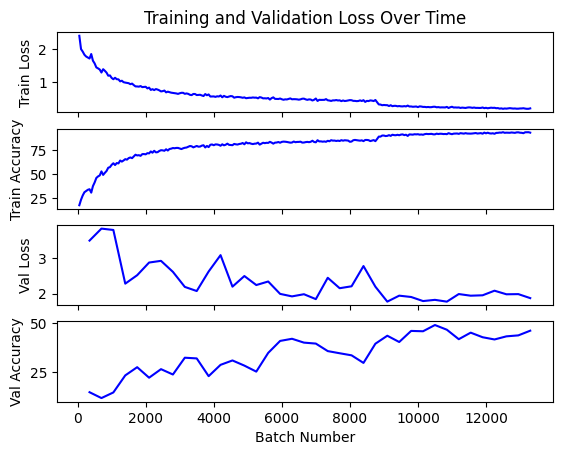

Epoch 39
Batch50, Loss: 0.172, Accuracy: 93.8%
Batch100, Loss: 0.189, Accuracy: 93.6%
Batch150, Loss: 0.192, Accuracy: 93.6%
Batch200, Loss: 0.178, Accuracy: 93.9%
Batch250, Loss: 0.180, Accuracy: 93.6%
Batch300, Loss: 0.176, Accuracy: 93.9%
Batch350, Loss: 0.178, Accuracy: 94.1%
Val Loss: 1.907, Val Accuracy: 45.6%
*****************************************



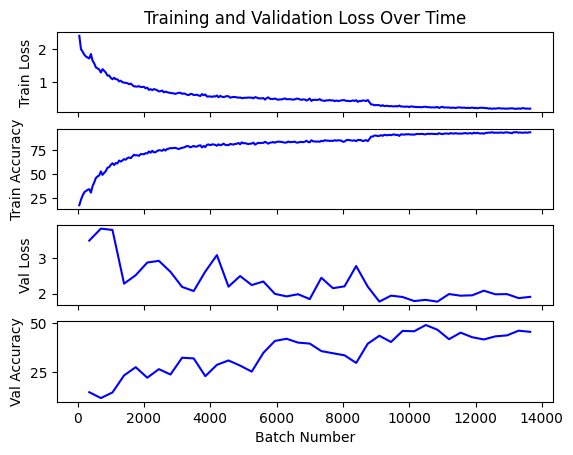

Epoch 40
Batch50, Loss: 0.171, Accuracy: 94.3%
Batch100, Loss: 0.186, Accuracy: 93.5%
Batch150, Loss: 0.176, Accuracy: 94.0%
Batch200, Loss: 0.172, Accuracy: 94.2%
Batch250, Loss: 0.179, Accuracy: 93.8%
Batch300, Loss: 0.173, Accuracy: 94.2%
Batch350, Loss: 0.179, Accuracy: 93.6%
Val Loss: 1.923, Val Accuracy: 45.5%
*****************************************



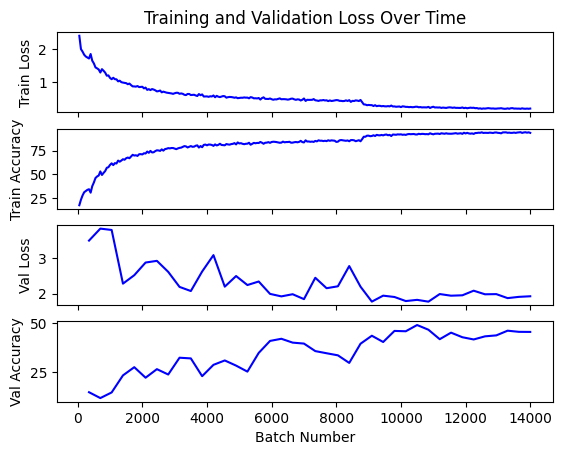

Epoch 41
Batch50, Loss: 0.179, Accuracy: 93.9%
Batch100, Loss: 0.171, Accuracy: 94.0%
Batch150, Loss: 0.179, Accuracy: 93.7%
Batch200, Loss: 0.178, Accuracy: 93.8%
Batch250, Loss: 0.169, Accuracy: 94.3%
Batch300, Loss: 0.189, Accuracy: 93.4%
Batch350, Loss: 0.174, Accuracy: 93.8%
Val Loss: 1.995, Val Accuracy: 44.5%
*****************************************



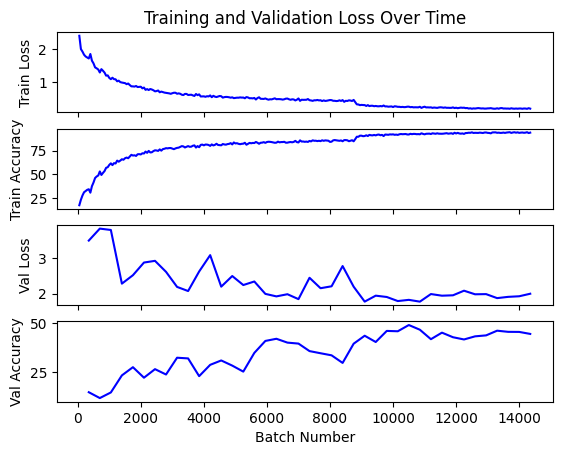

Epoch 42
Batch50, Loss: 0.182, Accuracy: 93.6%
Batch100, Loss: 0.166, Accuracy: 93.9%
Batch150, Loss: 0.182, Accuracy: 93.7%
Batch200, Loss: 0.184, Accuracy: 93.7%
Batch250, Loss: 0.182, Accuracy: 93.8%
Batch300, Loss: 0.173, Accuracy: 94.1%
Batch350, Loss: 0.175, Accuracy: 94.1%
Val Loss: 2.015, Val Accuracy: 44.7%
*****************************************



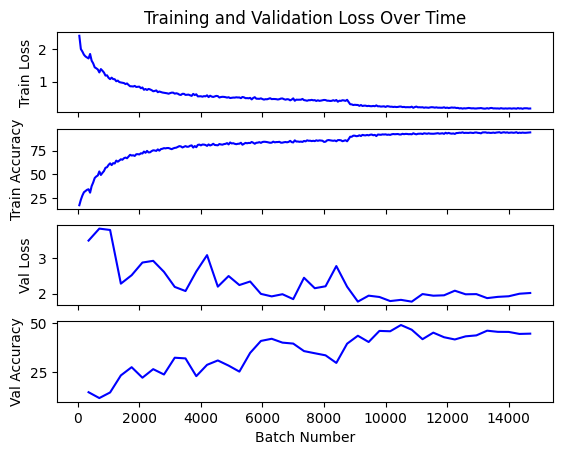

Epoch 43
Batch50, Loss: 0.177, Accuracy: 93.8%
Batch100, Loss: 0.182, Accuracy: 93.8%
Batch150, Loss: 0.176, Accuracy: 94.1%
Batch200, Loss: 0.170, Accuracy: 94.0%
Batch250, Loss: 0.171, Accuracy: 94.0%
Batch300, Loss: 0.175, Accuracy: 94.2%
Batch350, Loss: 0.171, Accuracy: 94.0%
Val Loss: 1.989, Val Accuracy: 45.0%
*****************************************



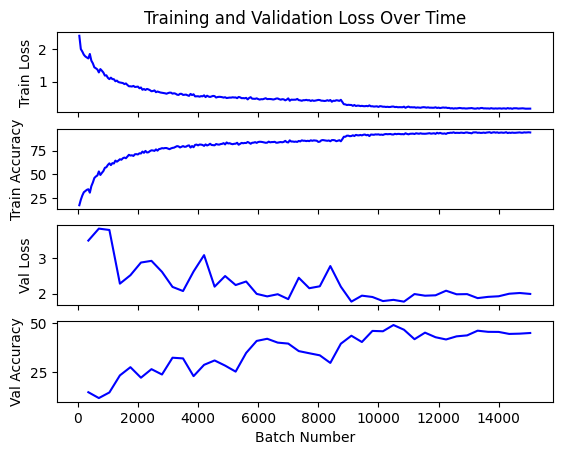

Epoch 44
Batch50, Loss: 0.173, Accuracy: 93.9%
Batch100, Loss: 0.171, Accuracy: 93.7%
Batch150, Loss: 0.181, Accuracy: 93.8%
Batch200, Loss: 0.177, Accuracy: 93.8%
Batch250, Loss: 0.169, Accuracy: 94.3%
Batch300, Loss: 0.168, Accuracy: 94.5%
Batch350, Loss: 0.171, Accuracy: 94.2%
Val Loss: 1.992, Val Accuracy: 44.6%
*****************************************



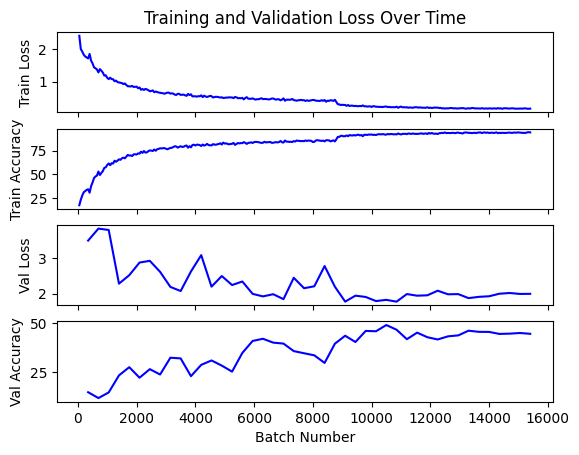

Epoch 45
Batch50, Loss: 0.177, Accuracy: 93.9%
Batch100, Loss: 0.175, Accuracy: 93.8%
Batch150, Loss: 0.178, Accuracy: 94.0%
Batch200, Loss: 0.163, Accuracy: 94.4%
Batch250, Loss: 0.170, Accuracy: 94.3%
Batch300, Loss: 0.179, Accuracy: 93.9%
Batch350, Loss: 0.177, Accuracy: 94.0%
Val Loss: 1.928, Val Accuracy: 45.9%
*****************************************



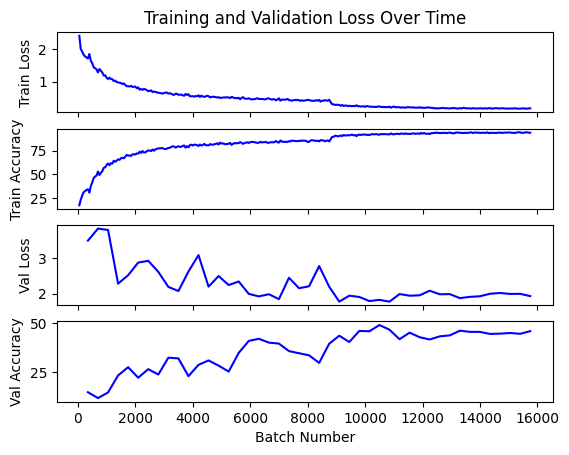

In [9]:
#Sets up Resnet, optimizer, and loss function
resnet = Resnet(n=3) # n determines size of network according to paper
resnet.to(device)
resnet.apply(he_init) # Use He/Kaiming initialization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

#Warms up the learning rate and then decays it according to the paper
warmup_scheduler = LinearLR(optimizer, start_factor=0.01, total_iters=5) # Added in addition to the paper
main_scheduler = MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1) #Paper uses [82, 123] for milestones
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[5])

#Initializes arrays to track training metrics
batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

#Trains the Resnet
num_epochs = 45 #164 in the paper
for i in range(num_epochs):
    print(f"Epoch {i+1}")

    #Training and metric updating
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(resnet, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    #Validation and metric updating
    losses_toadd, accuracy_toadd = validate_epoch(resnet, criterion)
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)
    scheduler.step()

    #Plot metrics after each epoch
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

In [ ]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
resnet.eval()
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

Accuracy 48.1


In [ ]:
test_iter = iter(testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: truck


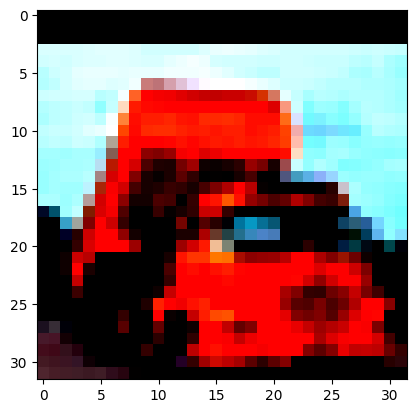

In [ ]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
guess_labels = resnet(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]]}")
print(f"Guess label: {class_names[guess_label]}")
plt.imshow(np_img.transpose((1, 2, 0)))